## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is the second course-work activity **Assignment 1 Part 2: Classification**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

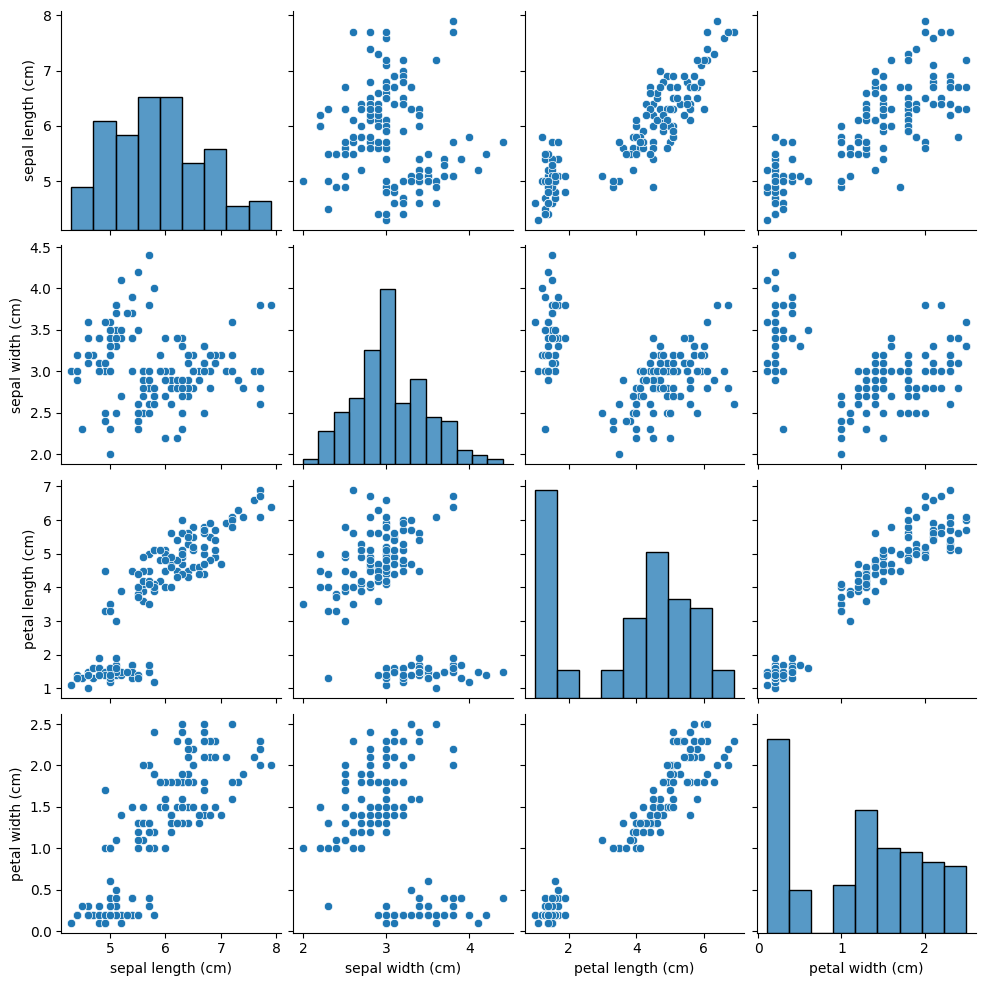

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [3]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="red">**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font>

Original Statistics:
Mean: tensor([5.8092, 3.0617, 3.7267, 1.1833])
Standard Deviation: tensor([0.8238, 0.4491, 1.7523, 0.7523])

Normalized Data Statistics:
Mean: tensor([-3.0597e-07, -1.2716e-07,  1.2318e-07,  6.7552e-08])
Standard Deviation: tensor([1.0042, 1.0042, 1.0042, 1.0042])


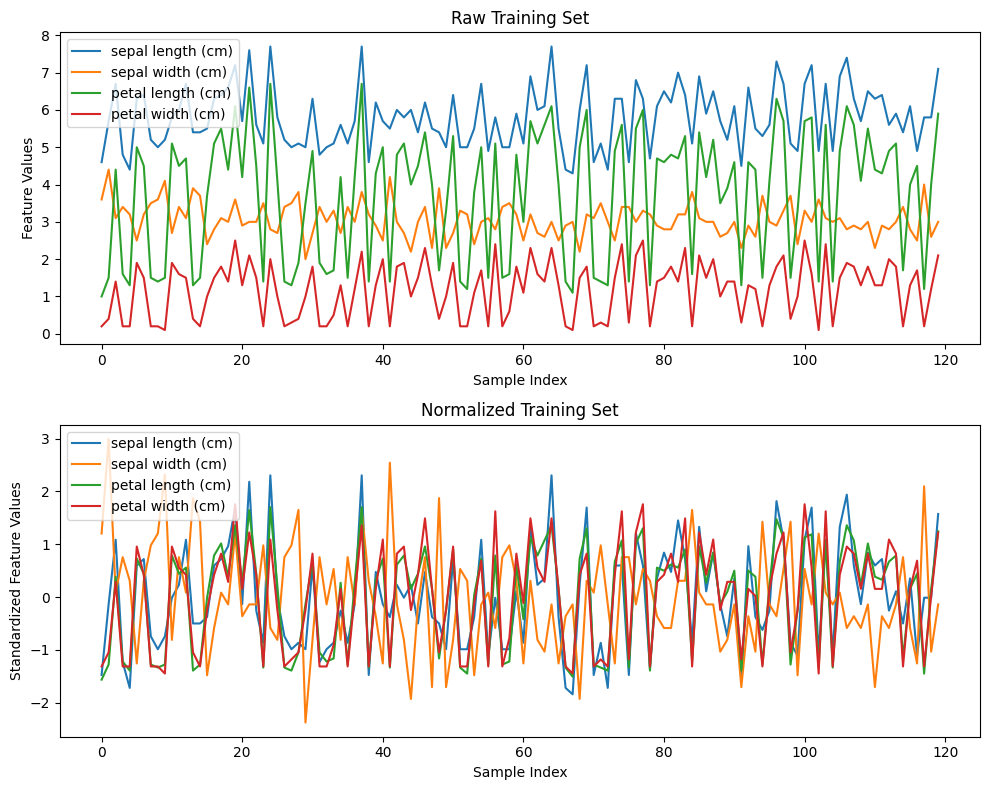

In [5]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
  safe_sigma = torch.where(sigma == 0, torch.ones_like(sigma), sigma)
  return (x - mu) / safe_sigma

mu = x_train.mean(dim=0, keepdim=True)
sigma = x_train.std(dim=0, unbiased=False, keepdim=True)
x_train_norm = norm_set(x_train, mu, sigma)
x_test_norm = norm_set(x_test, mu, sigma)

# Plotting the raw and normalized training sets
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Before normalization
print("Original Statistics:")
print("Mean:", x_train.mean(dim=0))
print("Standard Deviation:", x_train.std(dim=0))

# After normalization
print("\nNormalized Data Statistics:")
print("Mean:", x_train_norm.mean(dim=0))
print("Standard Deviation:", x_train_norm.std(dim=0))

feature_labels = iris_db.feature_names

# Plot raw data
axs[0].plot(x_train.numpy(), label=feature_labels)
axs[0].set_title('Raw Training Set')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Feature Values')
axs[0].legend()

# Plot normalized data
axs[1].plot(x_train_norm.numpy(), label=feature_labels)
axs[1].set_title('Normalized Training Set')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Standardized Feature Values')
axs[1].legend()

plt.tight_layout()
plt.show()


In [6]:
#Additional cell for further inspection 
def summarise(tensor, label):
    min_vals = tensor.min(dim=0).values
    max_vals = tensor.max(dim=0).values
    var_vals = tensor.var(dim=0, unbiased=False)

    summary = pd.DataFrame(
        {
            "min": min_vals.numpy(),
            "max": max_vals.numpy(),
            "range": (max_vals - min_vals).numpy(),
            "variance": var_vals.numpy(),
        },
        index=iris_db.feature_names,
    )
    print(f"\n{label}")
    display.display(summary.round(4))

summarise(x_train, "Raw training features")
summarise(x_train_norm, "Normalised training features")


Raw training features


,min,max,range,variance
sepal length (cm),4.3,7.7,3.4,0.6730
sepal width (cm),2.0,4.4,2.4,0.2000
petal length (cm),1.0,6.7,5.7,3.0451
petal width (cm),0.1,2.5,2.4,0.5612



Normalised training features


,min,max,range,variance
sepal length (cm),-1.8396,2.3049,4.1445,1.0
sepal width (cm),-2.3738,2.9924,5.3662,1.0
petal length (cm),-1.5625,1.7039,3.2664,1.0
petal width (cm),-1.4461,1.7576,3.2036,1.0


By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

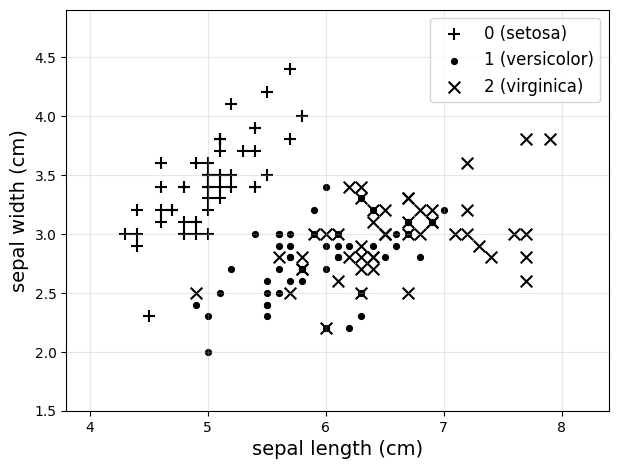

In [7]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
train_set_1 = x_train_norm[:, :2]
test_set_1 = x_test_norm[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

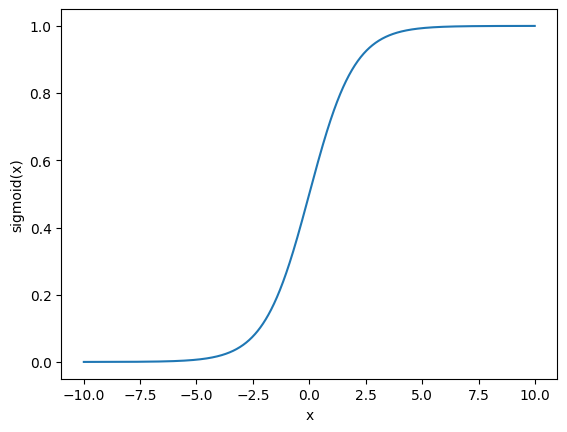

In [9]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  return 1.0 / (1.0 + torch.exp(-z))


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [10]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    z = x @ self.weight.T
    y = sigmoid(z)
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m}  \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [11]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
  return loss.mean()

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  gradient = (1/N) * torch.matmul((y_pred - y).T, X)
  model.weight = nn.Parameter(weight - lr * gradient, requires_grad=False)

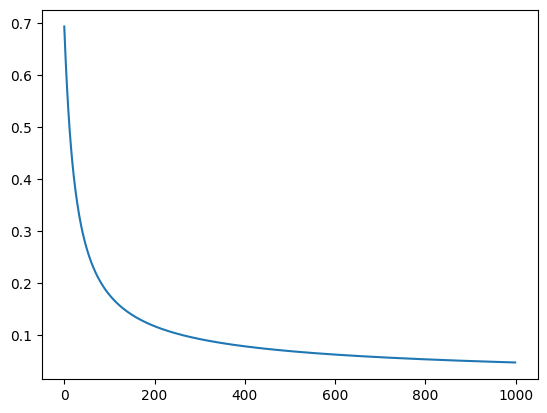

Parameter containing:
tensor([[-3.7592,  2.5346, -2.1277]])
Minimum cost: 0.04771796241402626


In [12]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.1 # 0.1 selected for proper convergence
train(model, train_set_1, setosa_train, alpha)

<font color="red"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font>

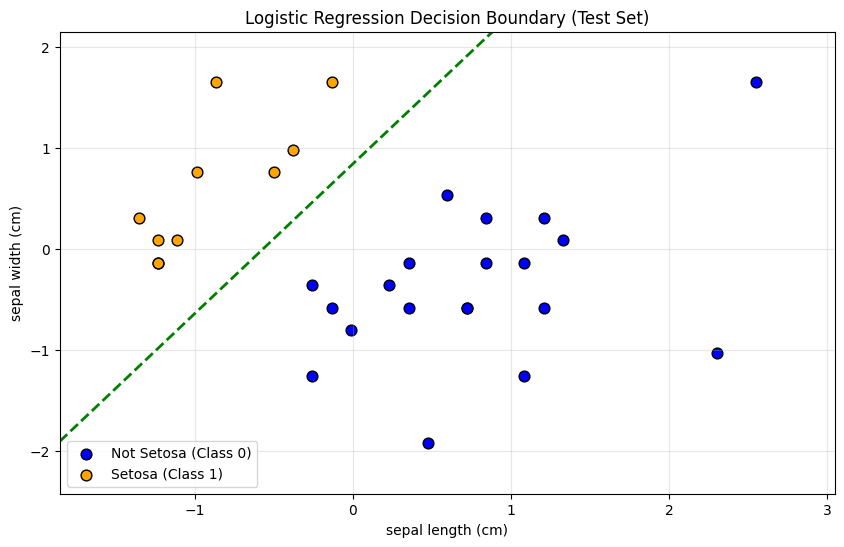

In [13]:
import numpy as np

# Extract learned weights from the trained model
weights = model.weight.detach().numpy().flatten()

# Prepare test data for plotting (first two features only, without bias column)
test_features = test_set_1[:, :2].numpy()
test_labels = setosa_test.numpy().flatten()

# Define plot boundaries with some padding
x_min, x_max = test_features[:, 0].min() - 0.5, test_features[:, 0].max() + 0.5
y_min, y_max = test_features[:, 1].min() - 0.5, test_features[:, 1].max() + 0.5

# Create a dense grid of points covering the feature space
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Add bias column (ones) to match the model's expected input shape
grid_with_bias = np.c_[grid_points, np.ones(grid_points.shape[0])]
grid_tensor = torch.from_numpy(grid_with_bias).float()

# Compute model predictions across the grid
with torch.no_grad():
    predictions = model(grid_tensor).numpy()

# Reshape predictions back to grid dimensions for contour plotting
predictions = predictions.reshape(xx.shape)

# Plot test set samples
plt.figure(figsize=(10, 6))

# Separate and plot each class
class_0_mask = (test_labels == 0)
class_1_mask = (test_labels == 1)

plt.scatter(
    test_features[class_0_mask, 0],
    test_features[class_0_mask, 1],
    c='blue',
    edgecolor='k',
    s=60,
    label='Not Setosa (Class 0)'
)

plt.scatter(
    test_features[class_1_mask, 0],
    test_features[class_1_mask, 1],
    c='orange',
    edgecolor='k',
    s=60,
    label='Setosa (Class 1)'
)

# Draw decision boundary at probability = 0.5
plt.contour(xx, yy, predictions, levels=[0.5], colors='green', linestyles='--', linewidths=2)

# Label axes with actual feature names
plt.xlabel(iris_db.feature_names[0])
plt.ylabel(iris_db.feature_names[1])
plt.title('Logistic Regression Decision Boundary (Test Set)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [14]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [15]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


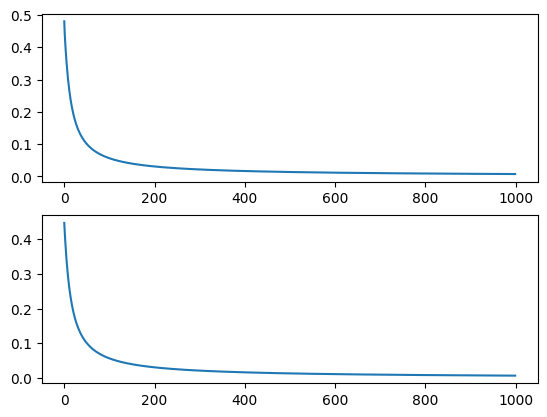

Minimum train cost: 0.0074031418189406395
Minimum test cost: 0.007264141924679279


In [16]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

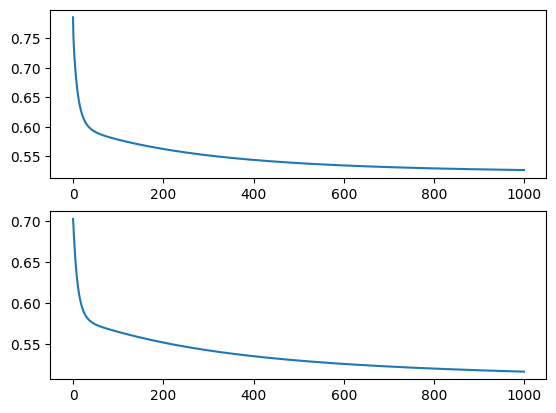

Minimum train cost: 0.5267826318740845
Minimum test cost: 0.5161035656929016


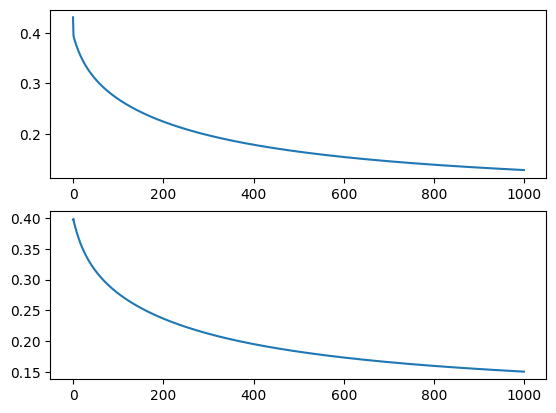

Minimum train cost: 0.12775424122810364
Minimum test cost: 0.15067142248153687


In [17]:
# Versicolor classifier (class 1)
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_train_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_test_labels = y_test[:, 1].reshape(-1, 1).float()
versicolor_optimiser = optim.SGD(versicolor_model.parameters(), alpha)

train(versicolor_model, x_train, versicolor_train_labels, x_test, versicolor_test_labels, versicolor_optimiser, alpha)

# Virginica classifier (class 2)
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_train_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_test_labels = y_test[:, 2].reshape(-1, 1).float()
virginica_optimiser = optim.SGD(virginica_model.parameters(), alpha)

train(virginica_model, x_train, virginica_train_labels, x_test, virginica_test_labels, virginica_optimiser, alpha)

<font color="red"> **Q7.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font>

In [18]:
# Get predictions from all three classifiers
setosa_model.eval()
versicolor_model.eval()
virginica_model.eval()

with torch.no_grad():
    setosa_probs = setosa_model(x_test).numpy().flatten()
    versicolor_probs = versicolor_model(x_test).numpy().flatten()
    virginica_probs = virginica_model(x_test).numpy().flatten()

# Stack probabilities (rows = samples, cols = classes)
# Useful for softmaxing later
all_probs = np.column_stack([setosa_probs, versicolor_probs, virginica_probs])

# Predict class with highest probability
predicted_idx = np.argmax(all_probs, axis=1)
true_idx = torch.argmax(y_test, dim=1).numpy()

# Build results table
results = pd.DataFrame({
    'Setosa_Prob': setosa_probs,
    'Versicolor_Prob': versicolor_probs,
    'Virginica_Prob': virginica_probs,
    'Predicted': [iris_db.target_names[i] for i in predicted_idx],
    'True_Class': [iris_db.target_names[i] for i in true_idx]
})

print(results)
### your code here

    Setosa_Prob  Versicolor_Prob  Virginica_Prob   Predicted  True_Class
0      0.001981         0.559916    1.928226e-01  versicolor  versicolor
1      0.993633         0.131638    3.412615e-07      setosa      setosa
2      0.000001         0.783809    9.960997e-01   virginica   virginica
3      0.002852         0.373717    2.223823e-01  versicolor  versicolor
4      0.001527         0.637563    1.069724e-01  versicolor  versicolor
5      0.989307         0.162493    1.123858e-06      setosa      setosa
6      0.035816         0.280417    2.179338e-02  versicolor  versicolor
7      0.000447         0.268161    6.037586e-01   virginica   virginica
8      0.000702         0.707761    4.658072e-01  versicolor  versicolor
9      0.012789         0.459565    4.255512e-02  versicolor  versicolor
10     0.000684         0.252503    5.662993e-01   virginica   virginica
11     0.983697         0.261842    3.325130e-06      setosa      setosa
12     0.996175         0.175632    2.183897e-07   

<font color="red"> **Q8.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font>

In [19]:
# Apply softmax to normalize probabilities
softmax_probs = torch.softmax(torch.tensor(all_probs), dim=1).numpy()

# Get final predictions after softmax
final_predictions = np.argmax(softmax_probs, axis=1)

# Calculate accuracy
correct = np.sum(final_predictions == true_idx)
accuracy = (correct / len(true_idx)) * 100

print(f"Test set accuracy: {accuracy:.2f}%")
print(f"Correctly classified: {correct}/{len(true_idx)} samples")



Test set accuracy: 100.00%
Correctly classified: 30/30 samples


## 3. The XOR problem

<font color="red"> **Q9.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font>

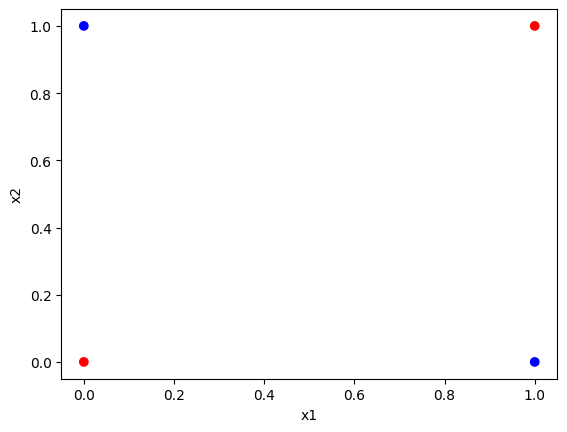

In [20]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()